# Домашнее задание по NLP # 1 [100 баллов]

In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:48, 1855.04it/s]


### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
        слов
        слов без стоп-слов
        лемм
        существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
        какое слово встречается чаще: "сотрудник" или "клиент"?
        сколько раз встречается слова: "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
import collections
unique_cities = collections.Counter(r['city'] for r in responses)
unique_banks = collections.Counter(r['bank_name'] for r in responses)

In [6]:
del unique_cities[None]

<BarContainer object of 5 artists>

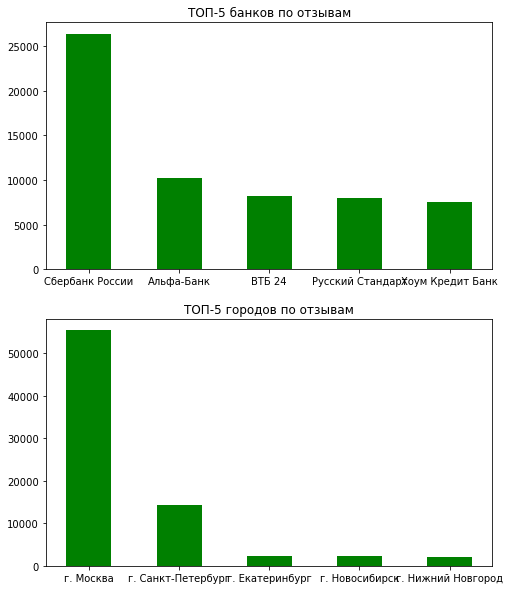

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

ax1.title.set_text('ТОП-5 банков по отзывам')
ax2.title.set_text('ТОП-5 городов по отзывам')

ax1.bar(*zip(*unique_banks.most_common(5)), width=0.5, color='g')
ax2.bar(*zip(*unique_cities.most_common(5)), width=0.5, color='g')

### 2. Постройте гистограмы длин слов в символах и в словах

In [8]:
unique_text = collections.Counter(len(r['text']) for r in responses)

<BarContainer object of 7384 artists>

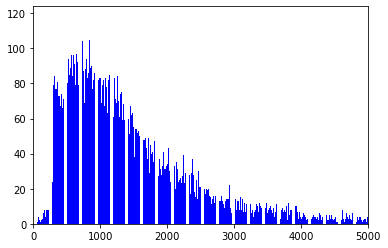

In [9]:
plt.xlim(0, 5000)
plt.bar(*zip(*unique_text.items()), color='b')

In [10]:
unique_word = collections.Counter(len(r['text'].split()) for r in responses)

<BarContainer object of 1724 artists>

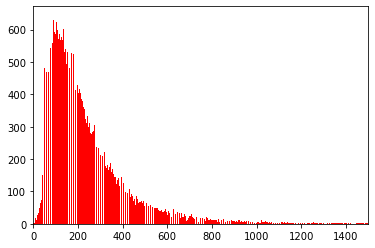

In [11]:
plt.xlim(0, 1500)
plt.bar(*zip(*unique_word.items()), color='r')

Видим, что в среднем символов в среднем отзыве в 5 раз больше, чем самих слов (приблизительно ср.значение около 1000 и 200, соответственно).

### 3. Найдите 10 самых частых:
        слов
        слов без стоп-слов
        лемм
        существительных

In [12]:
df = pd.DataFrame(responses)

In [13]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [14]:
sample = df.copy()
len(sample)

153499

In [15]:
sample.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


#### Наиболее часто встречающиеся слова:

In [16]:
import re
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

In [17]:
sample.text = sample.text.str.lower()
sample.text = sample.text.apply(words_only)

In [18]:
sample.text.iloc[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [19]:
from collections import Counter

In [20]:
wordCount = [word for text in sample.text for word in text.split()]

In [21]:
cnt = Counter(wordCount)

In [22]:
for i in cnt.most_common(10):
    print(i)

('в', 1330550)
('и', 1058997)
('не', 855335)
('на', 707935)
('что', 640057)
('я', 577500)
('с', 464037)
('по', 372769)
('мне', 320958)
('банка', 275906)


#### Наиболее часто встречающиеся слова без стоп-слов:

In [23]:
from nltk.corpus import stopwords

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г', 'года', 'руб', 'рублей', 'сумму']

In [24]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [25]:
sample.text = sample.text.apply(remove_stopwords)   

In [26]:
sample.text.iloc[0]

'добрый день являюсь клиентом банка поручителем кредитному договору являюсь каким либо другим лицом письменно оформившим отношения банком поводу урегулирования чьей либо задолженности начиная марта начали приходить бесконечные письма ооо примо коллект адрес город москва уваровский переулок дом квартира угрозами возбуждении уголовного дела отношении гражданина филиппова эдуарда владимировича который уклоняется уплаты взятых кредитов договор договор всей ответственностью хочу заверить вышеуказанный гражданин которого разыскиваете знаком моем адресе зарегистрирован каким образом удостоверившись подлинности документов оформили имя кредитный договор меньшей мере понятно почему вашей милости должна переживать бояться свое имущество письма доставляют серьезные неудобства нарушают мои гражданские права нарушают закон защите персональных данных убедительно прошу прекратить посылать адрес письма угрозами вопросам которым имею отношения случае отклонения моей претензии буду вынуждена обратиться ж

In [27]:
non_stopwordCount = [word for text in sample.text for word in text.split()]

In [28]:
cnt = Counter(non_stopwordCount)

In [29]:
for i in cnt.most_common(10):
    print(i)

('банка', 275906)
('банк', 215426)
('деньги', 131201)
('карту', 105829)
('карты', 101821)
('кредит', 81136)
('день', 76552)
('банке', 72169)
('заявление', 70423)
('очень', 66824)


#### Наиболее часто встречающиеся леммы:

In [30]:
from pymystem3 import Mystem

In [31]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [32]:
#test = sample.text.iloc[0]

In [33]:
#lemmatize(test)

##### Лемматизируем только первые N = 100 отзывов, т.к. лемматизация всего массива данных занимает очень много времени (несколько часов)

In [34]:
%%time
for i in range(0,100):
    lemma_text = sample.text.iloc[i]
    lemma_text = lemmatize(lemma_text)
    sample.text.iloc[i] = lemma_text

C:\Users\Nikita\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 1min 35s


In [35]:
sample.text.iloc[50]

'добрый день хотеть написать свой отзыв работа банк приходиться сталкиваться неприятность выплачивать кредит полностью являться офис банк ростов дон ул театральный получать рука справка погашение задолженость следующий шаг мой изъявление желание закрытие счет оказываться счет иметься переплата копейка написать заявление зачисление деньги счет банк получать справка закрытие мой счет май я сделать звонок банк цель выяснение почему долго списываться сумма копейка мой счет закрывать получать ответ копейка сей пора висеть сколько ждать простой формальный процедура почему клиент банк который сделать один просрочка платеж течение должный ждать тратить свой деньги звонок банк поездка туда проживать новочеркасск испытывать стресс'

In [44]:
#%%time 
#sample.text = sample.text.apply(lemmatize)

In [45]:
#sample.text.iloc[0]

In [36]:
lemmaCount = [word for text in sample.text[:100] for word in text.split()]

In [37]:
cnt = Counter(lemmaCount)

In [38]:
for i in cnt.most_common(10):
    print(i)

('банк', 315)
('карта', 162)
('кредит', 110)
('мой', 83)
('клиент', 73)
('счет', 72)
('день', 70)
('который', 66)
('деньги', 66)
('договор', 63)


#### Убираем стоп-леммы

In [39]:
mystoplemmas = ['день', 'данный', 'который', 'ваш', 'свой', 'месяц', 'какой']
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [40]:
%%time
for i in range(0,100):
    lemma_text = sample.text.iloc[i]
    lemma_text = remove_stoplemmas(lemma_text)
    sample.text.iloc[i] = lemma_text

Wall time: 276 ms


In [41]:
StopLemmaCount = [word for text in sample.text[:100] for word in text.split()]

In [42]:
cnt = Counter(StopLemmaCount)

In [43]:
for i in cnt.most_common(10):
    print(i)

('банк', 315)
('карта', 162)
('кредит', 110)
('мой', 83)
('клиент', 73)
('счет', 72)
('деньги', 66)
('договор', 63)
('сотрудник', 55)
('сказать', 52)


In [101]:
#pip install wordcloud

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

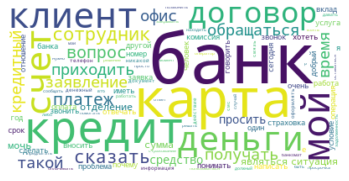

In [45]:
word_freq = [i for i in cnt.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Наиболее часто встречающиеся существительные

In [46]:
### не понял, как подступиться к задаче

### 4. Постройте кривые Ципфа и Хипса

#### Закон Ципфа
Эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

В любом достаточно большом тексте ранг слова обратно пропорционален его частоте: $f = \frac{a}{r}$

$f$ – частота слова, $r$  – ранг слова, $a$  – параметр, для славянских языков – около 0.07

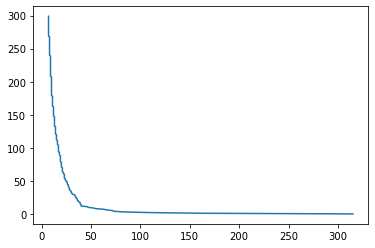

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

#### Закон Хипса

С увеличением длины текста (количества токенов), количество слов увеличивается в соответствии с законом: $|V| = K*N^b$


$N$  –  число токенов, $|V|$  – количество слов в словаре, $K, b$  –  параметры, обычно $K \in [10,100], b \in [0.4, 0.6]$

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

In [67]:
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 153499/153499 [06:28<00:00, 395.47it/s]


In [75]:
#fig, ax = plt.subplots()
#ax.plot(n_tokens, n_words)
#plt.show()

### 5. Ответьте на следующие вопросы:
- какое слово встречается чаще: "сотрудник" или "клиент"?
- сколько раз встречается слова: "мошенничество" и "доверие"?

In [60]:
print('Кол-во раз встречается слово "сотрудник": {}'.format(cnt['сотрудник']))
print('Кол-во раз встречается слово "клиент": {}'.format(cnt['клиент']))

Кол-во раз встречается слово "сотрудник": 55
Кол-во раз встречается слово "клиент": 73


In [61]:
print('Кол-во раз встречается слово "мошенничество": {}'.format(cnt['мошенничество']))
print('Кол-во раз встречается слово "доверие": {}'.format(cnt['доверие']))

Кол-во раз встречается слово "мошенничество": 1
Кол-во раз встречается слово "доверие": 2


### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [78]:
def get_grade_to_tokens(df):
    tokens_by_grade = {}
    for grade in set(df['rating_grade']):
        
        # берём только относительно большие темы
        if df['rating_grade'].value_counts()[grade] > 100:
            
            # берём по сто случайных текстов из каждой темы
            sample = df[df['rating_grade']==grade].sample(n=100)
            
            # предобрабатываем
            sample.text = sample.text.str.lower()
            sample.text = sample.text.apply(words_only)
            sample.text = sample.text.apply(remove_stopwords) 
            sample.text = sample.text.apply(lemmatize)
            sample.text = sample.text.apply(remove_stoplemmas) 

            tokens_by_grade[grade] = [tok for text in sample.text for tok in text.split()]
            
    return tokens_by_grade

In [83]:
tokens_by_grade = get_grade_to_tokens(df.dropna())

In [85]:
tokens_by_grade.keys()

dict_keys([1.0, 2.0, 3.0, 4.0, 5.0])

In [91]:
grade_texts = tokens_by_grade[1]

In [92]:
grade_texts[:10]

['ипотечный',
 'кредит',
 'мдм',
 'банк',
 'оплачивать',
 'просрочка',
 'опережение',
 'график',
 'оплачивать',
 'последний']

In [93]:
grade_texts = tokens_by_grade[5]

In [94]:
grade_texts[:10]

['добрый',
 'несмотря',
 'крайне',
 'негативный',
 'опыт',
 'получение',
 'кредит',
 'банк',
 'август',
 'подробный']

Извлекаем биграммы по разным мерам связности:

In [95]:
import nltk
from nltk.collocations import *

In [96]:
bigram_measures = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграм
finder = BigramCollocationFinder.from_words(grade_texts) # класс для хранения и извлечения биграм

In [97]:
N_best = 100

In [98]:
%%time 
finder.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже трех раз

# выбираем топ-100 биграм по каждой мере
raw_freq_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.raw_freq, N_best)]
tscore_ranking = [' '.join(i) for i in finder.nbest(bigram_measures.student_t, N_best)]
pmi_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.pmi, N_best)]
chi2_ranking =  [' '.join(i) for i in finder.nbest(bigram_measures.chi_sq, N_best)]

Wall time: 9.52 ms


Результаты:

In [99]:
rankings = pd.DataFrame({
    'chi2': chi2_ranking,
    't-score' : tscore_ranking,
    'pmi': pmi_ranking,
    'raw_freq':raw_freq_ranking
})
rankings = rankings[['raw_freq', 'pmi', 't-score', 'chi2']]
rankings.head(10)

,raw_freq,pmi,t-score,chi2
0,другой банк,марьин роща,другой банк,марьин роща
1,кредитный карта,обеденный перерыв,кредитный карта,восточный экспресс
2,сотрудник банк,форс мажорный,сотрудник банк,русский стандарт
3,открывать вклад,мажорный обстоятельство,открывать вклад,санкт петербург
4,интернет банк,русский стандарт,приятно удивлять,обеденный перерыв
5,приятно удивлять,санкт петербург,интернет банк,форс мажорный
6,отделение банк,сей пора,отношение клиент,индивидуальный подход
7,отношение клиент,восточный экспресс,очень довольный,мажорный обстоятельство
8,офис банк,проспект мир,отделение банк,ч тко
9,очень довольный,ч тко,условие кредитование,сей пора


Похожи ли списки биграмм? Посчитаем корреляцию и визуализируем

In [100]:
from scipy.stats import spearmanr
import seaborn as sns
%matplotlib inline

In [101]:
corr = spearmanr(rankings).correlation

In [102]:
corr

array([[ 1.        , -0.07455146,  0.04267627,  0.16160816],
       [-0.07455146,  1.        ,  0.04853285,  0.02784278],
       [ 0.04267627,  0.04853285,  1.        ,  0.04886889],
       [ 0.16160816,  0.02784278,  0.04886889,  1.        ]])

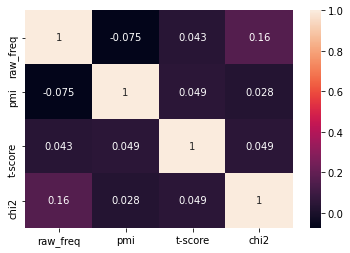

In [103]:
sns.heatmap(corr, annot=True, xticklabels = list(rankings), yticklabels = list(rankings))

#### Используем меру контрастности

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [143]:
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for grade, tokens in tokens_by_grade.items()])
feature_names = tfidf.get_feature_names() 
dense = tfidf_matrix.todense()

In [144]:
grade_id = 4

In [145]:
text = dense[grade_id].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)

In [146]:
tfidf_ranking = []
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:40]:
    tfidf_ranking.append(phrase)

In [147]:
rankings = pd.DataFrame({'tf-idf': tfidf_ranking})
rankings.head(10)

,tf-idf
0,банк
1,карта
2,вклад
3,очень
4,кредит
5,сотрудник
6,отделение
7,деньги
8,время
9,клиент


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim.

In [148]:
from gensim.summarization import keywords

In [152]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [157]:
def get_bank_to_tokens(df):
    tokens_by_bank = {}
    for bank in set(df['bank_name']):
        
        # берём только относительно большие темы
        if df['bank_name'].value_counts()[bank] > 1000:
            
            # берём по сто случайных текстов из каждой темы
            sample = df[df['bank_name']==bank].sample(n=100)
            
            # предобрабатываем
            sample.text = sample.text.str.lower()
            sample.text = sample.text.apply(words_only)
            sample.text = sample.text.apply(remove_stopwords) 
            sample.text = sample.text.apply(lemmatize)
            sample.text = sample.text.apply(remove_stoplemmas) 

            tokens_by_bank[bank] = [tok for text in sample.text for tok in text.split()]
            
    return tokens_by_bank

In [158]:
tokens_by_bank = get_bank_to_tokens(df.dropna())

In [159]:
tokens_by_bank.keys()

dict_keys(['Ситибанк', 'Авангард', 'Тинькофф Банк', 'ЮниКредит Банк', 'Сбербанк России', 'Ханты-Мансийский банк Открытие', 'Хоум Кредит Банк', 'Промсвязьбанк', 'Связной Банк', 'Альфа-Банк', 'Московский Кредитный Банк', 'ВТБ 24', 'Райффайзенбанк', 'Русский Стандарт', 'Ренессанс Кредит', 'Национальный Банк «Траст»', 'ОТП Банк', 'Банк Москвы'])

In [160]:
bank_texts = tokens_by_bank['Сбербанк России']

In [161]:
bank_texts[:10]

['декабрь',
 'загружать',
 'деньги',
 'платежный',
 'терминал',
 'сбербанк',
 'отключаться',
 'охранник',
 'сказать',
 'постоянно']

In [162]:
%%time
text = ' '.join(bank_texts)
kw = keywords(text)

Wall time: 1.11 s


In [164]:
rankings = pd.DataFrame({'Text Rank': kw.split('\n')})
rankings.head(20)

,Text Rank
0,банк
1,карта
2,деньги
3,сказать
4,операция
5,мои обращение
6,вопрос
7,номер
8,платежныи терминал сбербанк
9,работать сотрудник


In [165]:
bank_texts = tokens_by_bank['Тинькофф Банк']

In [166]:
bank_texts[:10]

['понадобиться',
 'небольшой',
 'сумма',
 'наличный',
 'новый',
 'интернет',
 'банка',
 'замечать',
 'возможность',
 'оформление']

In [167]:
%%time
text = ' '.join(bank_texts)
kw = keywords(text)

Wall time: 1.14 s


In [168]:
rankings = pd.DataFrame({'Text Rank': kw.split('\n')})
rankings.head(20)

,Text Rank
0,мои
1,вопрос
2,деньги
3,очень
4,положительныи решение ожидать звонок специалис...
5,клиент
6,держать далее быть пользоваться карта
7,получать
8,сотрудник сказать
9,проблема


## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5):

3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
4. 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
5. 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

Ниже написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [56]:
N1 = 2000
N2 = 2000

negative_grade = 1
positive_grade = 5

In [61]:
negative_sample = df[df['rating_grade']==negative_grade].sample(n=N1)
positive_sample = df[df['rating_grade']==positive_grade].sample(n=N2)

sample = pd.concat([negative_sample, positive_sample])

In [86]:
sample.text = sample.text.str.lower()
sample.text = sample.text.apply(words_only)
sample.text = sample.text.apply(remove_stopwords) 
sample.text = sample.text.apply(lemmatize)
sample.text = sample.text.apply(remove_stoplemmas) 

In [87]:
X = sample['text']
y = sample['rating_grade']

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [91]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range={4, 6})),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [92]:
clf.score(X_test, y_test)

0.6758333333333333

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = clf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print('\n')
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[431 191]
 [198 380]]


Classification Report
              precision    recall  f1-score   support

         1.0       0.69      0.69      0.69       622
         5.0       0.67      0.66      0.66       578

    accuracy                           0.68      1200
   macro avg       0.68      0.68      0.68      1200
weighted avg       0.68      0.68      0.68      1200

